## This notebook will utilize machine learning techniques to predict future and assess past stock prices. This example will use an LSTM to perform an analysis on Apple's stock price.

### LSTM (long short-term memory) models are particularly useful for time series data, as they are designed to remember and learn from many historical data points.

In [2]:
import tensorflow as tf
from tensorflow import keras #library to be used for the LSTM model
import pandas as pd #create clean and convenient dataframes for storing stock data
import numpy as np #quickly perform calculations on pandas dataframes
import matplotlib.pyplot as plt  #create detailed plots of the data
import seaborn as sns; sns.set() #sets the plotting style/theme of pyplot plots

### yfinance is a convenient library for downloading historical stock data through the Yahoo Finance API.

In [3]:
import yfinance as yf

In [4]:
aapl_df=yf.download("AAPL") #download and save apple's historical stock data into a pandas dataframe
#any ticker on yahoo finance (MSFT, TSLA, etc.) can be used as well

[*********************100%***********************]  1 of 1 completed


In [5]:
aapl_df #prints the first 5 and last 5 rows of the dataframe

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.405683,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.384517,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.356296,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.365115,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375698,18362400
...,...,...,...,...,...,...
2020-07-27,374.839996,379.619995,373.920013,379.239990,379.239990,30303500
2020-07-28,377.470001,378.200012,372.989990,373.010010,373.010010,25906400
2020-07-29,375.000000,380.920013,374.850006,380.160004,380.160004,22582300


### We are primarily interested in the daily closing price, so we can make a plot of this data to get an idea of what we are working with.

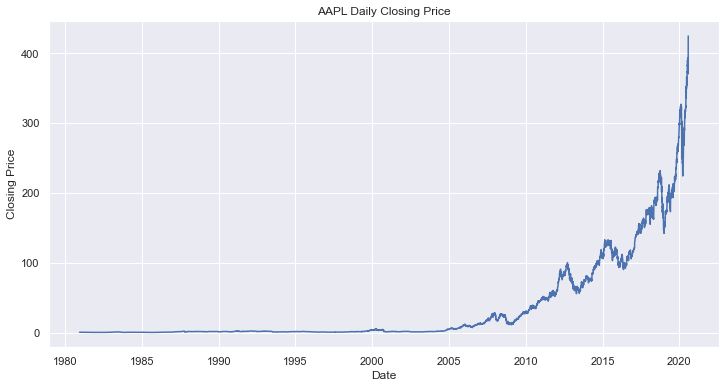

In [6]:
plt.figure(figsize=(12,6))      #sets the size of the figure
plt.plot(aapl_df.index, aapl_df['Close']) #plots the index (in this case, the date) along the x-axis and the closing price along the y-axis
plt.xlabel("Date") #adds the x-axis label
plt.ylabel("Closing Price") #adds the y-axis label
plt.title("AAPL Daily Closing Price") #adds the title
plt.show()  #displays the figure and elements added above

### Not much activity is observed in the pre-2005 data, so we will use only the data from 2005 onward.

In [7]:
aapl_df=aapl_df[aapl_df.index.year>=2005] #subset the dataframe to only include data points in the year 2005 and beyond

In [8]:
aapl_df #print the first and last 5 rows to make sure the data starts at 2005

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,4.627143,4.650714,4.471428,4.520714,3.913571,172998000
2005-01-04,4.556428,4.676429,4.497857,4.567143,3.953765,274202600
2005-01-05,4.604286,4.660714,4.575000,4.607143,3.988392,170108400
2005-01-06,4.619286,4.636428,4.523571,4.610714,3.991483,176388800
2005-01-07,4.642857,4.973571,4.625000,4.946429,4.282110,556862600
...,...,...,...,...,...,...
2020-07-27,374.839996,379.619995,373.920013,379.239990,379.239990,30303500
2020-07-28,377.470001,378.200012,372.989990,373.010010,373.010010,25906400
2020-07-29,375.000000,380.920013,374.850006,380.160004,380.160004,22582300


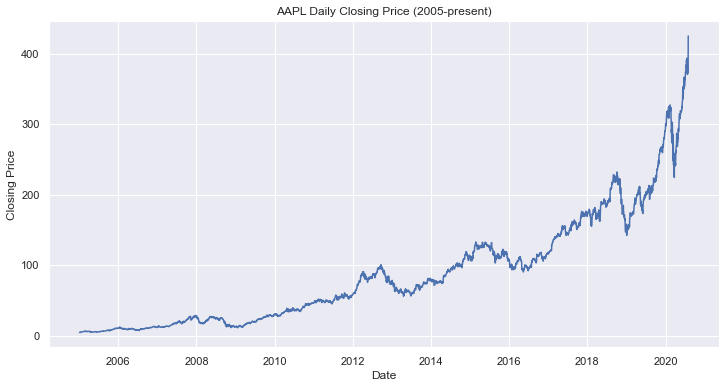

In [9]:
#identical to the previous plot, but does not include pre-2005 data
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("AAPL Daily Closing Price (2005-present)")
plt.show()

#### A quick check for possible missing data:

In [10]:
aapl_df.isna().sum() #takes the sum of how many missing data points are in each column

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
aapl_df.dtypes #prints out which data type each column is to make sure each is the proper type

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

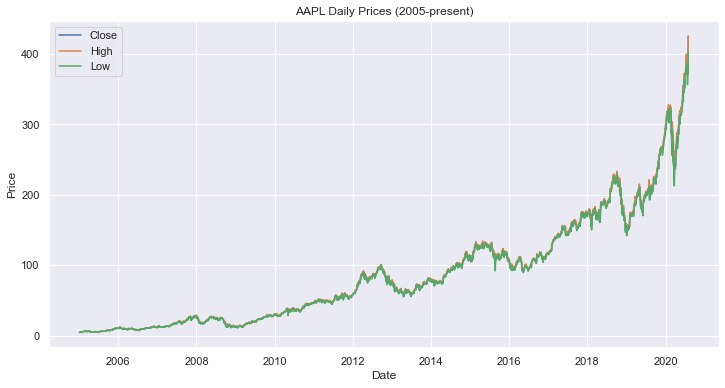

In [12]:
plt.figure(figsize=(12,6)) #set figure size
plt.plot(aapl_df.index, aapl_df['Close'], label="Close") #label is used to name the line in the plot's legend
plt.plot(aapl_df.index, aapl_df['High'], label="High") #plot the daily high price
plt.plot(aapl_df.index, aapl_df['Low'], label="Low") #plot the daily low price
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL Daily Prices (2005-present)")
plt.show()

## 7-day and 30-day rolling averages are calculated to help smooth out the curve, making it less erratic/jagged and short-term trends more apparent.

In [13]:
#calculates the 7 day rolling average and puts it in a column called "sma7" in the dataframe
aapl_df=aapl_df.assign(sma7=aapl_df['Close'].rolling(7).mean().values)

In [14]:
#calculates the 30 day rolling average and puts it in a column called "sma30" in the dataframe
aapl_df=aapl_df.assign(sma30=aapl_df['Close'].rolling(30).mean().values)

In [15]:
aapl_df.tail() #prints out the last 5 rows of the dataframe

,Open,High,Low,Close,Adj Close,Volume,sma7,sma30
Date,,,,,,,,
2020-07-27,374.839996,379.619995,373.920013,379.239990,379.239990,30303500,382.415710,370.849331
2020-07-28,377.470001,378.200012,372.989990,373.010010,373.010010,25906400,380.658569,371.849998
2020-07-29,375.000000,380.920013,374.850006,380.160004,380.160004,22582300,378.762857,372.785999
2020-07-30,376.750000,385.190002,375.070007,384.760010,384.760010,38797600,378.300001,373.891666
2020-07-31,411.535004,425.660004,403.359985,425.040009,425.040009,91201476,383.435717,376.335332


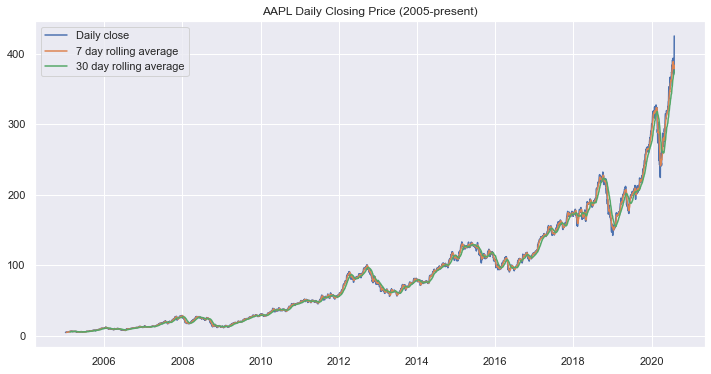

In [16]:
plt.figure(figsize=(12,6)) #set figure size
plt.plot(aapl_df.index, aapl_df['Close'], label="Daily close") #line plot of the closing price
plt.plot(aapl_df.index, aapl_df['sma7'], label="7 day rolling average") #line plot of the 7 day average
plt.plot(aapl_df.index, aapl_df['sma30'], label="30 day rolling average") #line plot of the 30 day average
plt.legend() #adds a legend/key to the plot
plt.title("AAPL Daily Closing Price (2005-present)") #adds title
plt.show() #displays the figure and elements added above

#### A closer look at more recent prices:

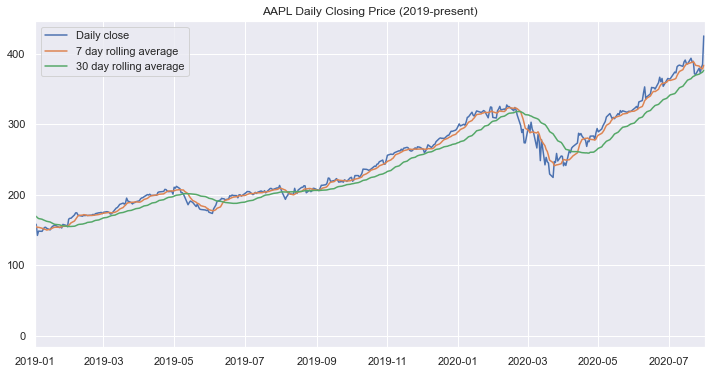

In [17]:
#identical to previous plot
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'], label="Daily close")
plt.plot(aapl_df.index, aapl_df['sma7'], label="7 day rolling average")
plt.plot(aapl_df.index, aapl_df['sma30'], label="30 day rolling average")
plt.legend()

#sets the limits of the graph to show only the data from January 1 2019 to today
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp.today())

plt.title("AAPL Daily Closing Price (2019-present)")
plt.show()

### Compared to the raw data, short term dips and rises are much more apparent in the 7- and 30-day rolling averages.

### Since this is time series data, it is worth taking a look at the (partial) autocorrelation for this data. The partial autocorrelation can tell us which historical data points are related/correlated to the present data point.

In [18]:
from statsmodels.tsa.stattools import acf, pacf #import autocorrelation and partial autocorrelation functions

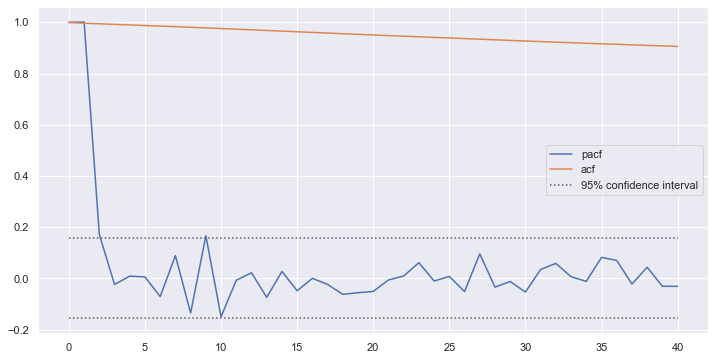

In [19]:
aapl_acf=acf(aapl_df['Close'].values, fft=True)   #calculates the acf using the fast fourier transform
#the fast fourier transform is an algorithm that makes computation much faster

aapl_pacf=pacf(aapl_df['Close'].values, method='ols') #calculates the pacf with the ordinary least squares method

plt.figure(figsize=(12,6))
plt.plot(aapl_pacf, label='pacf') #create a lineplot for the pacf
plt.plot(aapl_acf, label='acf') #create a lineplot for the acf

#plots the 95% confidence interval of the pacf to detect which time lags may be statistically significant
plt.hlines([1/np.sqrt(len(aapl_acf)), -1/np.sqrt(len(aapl_acf))],
           xmin=0, xmax=40, alpha=0.7,
           linestyles='dotted', label='95% confidence interval')

plt.legend()
plt.show()

### The current data point, $x_t$, is only dependent on the next previous data point. There is little to no signifcant correlation between it and other data points, as the other points are inside of the 95% confidence interval.

### Due to the  independent nature of the data points and overall lack of patterns, such as seasonality, an LSTM would be quite useful for this dataset.

#### First, the data is normalized to the range $(0, 1)$.

In [20]:
from sklearn.preprocessing import MinMaxScaler
#scales down the data to a specified range
#neural networks typically run more efficiently, and are more stable, when numbers are within a small range

In [21]:
scaler=MinMaxScaler(feature_range=(0, 1)) #our scaler will set our data to lie within the interval (0,1)

### 80% of the data is used for training, with the remaining 20% used for testing.

In [22]:
train_size=int(len(aapl_df)*0.8) #set the training size to be 80% of the data points
test_size=len(aapl_df)-train_size #sets the testing size to be the remaining 20%

In [23]:
train_size, test_size, len(aapl_df) #checking to make sure the values are calculated correctly

(3137, 785, 3922)

In [24]:
#set the train data to be the first 80% of data points
#the 0 after the comma in [0:train_size,0] means to only include the first row (the closing price) in our training data
train_data=np.array(aapl_df.iloc[0:train_size,0])

#set the train data to be the last 20% of data points
test_data=np.array(aapl_df.iloc[train_size:,0])

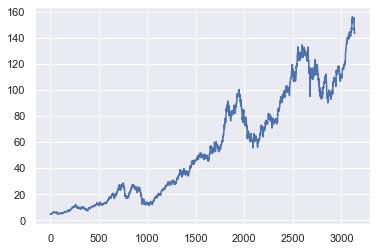

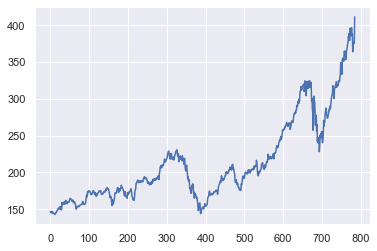

In [25]:
#create two separate plots to verify the data was split correctly
plt.plot(train_data)
plt.show()
plt.plot(test_data)
plt.show()

### Now that the data is split, we can apply our scaler to the data.

In [26]:
training_set_scaled = scaler.fit_transform(train_data.reshape(-1,1)) #reshape the training data
testing_set_scaled = scaler.fit_transform(test_data.reshape(-1,1)) #reshape the testing data

In [27]:
seq_length=50 #seq_length tells how many sequential data points are used for each element of the array
#50 means 50 data points will be used
#for instance, the first element of the array will be data points 1-50
#the second element of the array will be data points 2-51
#third element will be data points 3-52, and so on

X_train = [] #prepare an empty list for the input
y_train = [] #prepare an empty list for the output
for i in range(len(train_data)-seq_length):
    X_train.append(training_set_scaled[i:i+seq_length, 0])
    y_train.append(training_set_scaled[i+seq_length, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [28]:
X_train.shape, y_train.shape

((3087, 50, 1), (3087,))

In [ ]:
X_train[0]

## Creating the LSTM model

### Because this data has only one input and one output, a sequential model is more useful than a functional model, which is better suited for data with multiple inputs and/or outputs. 

In [30]:
#import the functions we will use to construct our LSTM model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [31]:
model = Sequential() #initialize the model

#adds an LSTM layer with 50 neurons - a bit of an arbitrary choice, but with over 3,000 data points, more neurons
#can capture more complex patterns in the data
#return_sequences tells the layer to send info from all previous layers to the next one instead of only the previous layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#dropout can help prevent overfitting
#these dropout layers drop 20% of input units by setting them to 0
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


#the Dense layer will function as our output for what the predicted value is
#it only has 1 unit because it is predicting a one-dimensional output (the stock price)
model.add(Dense(units=1))

#compile lets us configure which optimizer, loss metric, etc. we want to use for our model
#optimizer sets the learning rate and other parameters that affect the model's learning speed
#loss sets the way that the model calculates how much error there is
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#the model is fitted on the training data over 50 epochs
#each epoch updates the model weights to try and make it more accurate
#the model will run through the training data 50 times
#a batch size of 30 means 30 data points are input into and processed in the model before updating the model's weights and parameters
#verbose controls how detailed the output is when training the model
#validation_split controls how much data is held out for validation of model performance, in this case we hold out 10%
history = model.fit(X_train, y_train,
                    epochs=50, batch_size=30,
                    verbose=2, validation_split=0.1)

### We can make a plot of the training and validation losses to assess the model's performance after each epoch.

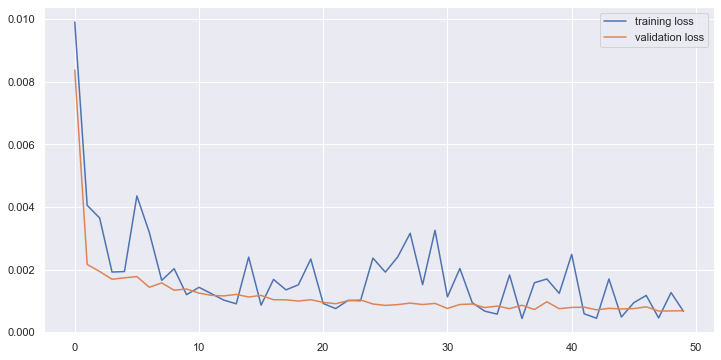

In [33]:
plt.figure(figsize=(12,6))
plt.plot(np.array(list(history.history.values()))[0]) #line plot of the training loss
plt.plot(np.array(list(history.history.values()))[1]) #line plot of the validation loss
plt.legend(['training loss','validation loss'])
plt.show()

### The model's training loss greatly decreases after about 5 epochs and continues to slowly decrease through the remaining runs. The validation loss experiences occasional spikes, but as the model continues to train and update, the spikes are not as big. However, this is expected due to the overall unpredictable and random nature of stocks.

### Now we will prepare the test data in order to evaluate our model.

In [34]:
dataset_total = aapl_df.iloc[:,0] #assign dataset_total to be the entire Close column

#inputs will store the datapoints we are going to predict (everything after the training set)
inputs = dataset_total[len(dataset_total)-seq_length-len(test_data)+1:].values
inputs = inputs.reshape(-1,1) #reshape the array to be used for the model
inputs = scaler.transform(inputs) #apply our scaler
X_test = [] #create an empty list to hold the data

for i in range(len(test_data)): #using only the test data for predictions
    X_test.append(inputs[i:i+seq_length, 0]) #same idea as before with seq_length
#the first element of the array will be data points 1-50
#the second element of the array will be data points 2-51
#third element will be data points 3-52, and so on

X_test = np.array(X_test) #convert the list to a numpy array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #reshape the array to use in our model

predicted_stock_price = model.predict(X_test) #create predictions for future stock prices on the test data
predicted_stock_price = scaler.inverse_transform(predicted_stock_price) #undo the scaler to get back real values

In [35]:
X_test.shape, predicted_stock_price.shape #checking the length of each array to ensure previous code ran properly

((785, 50, 1), (785, 1))

### Now that we have made our predictions, we can plot it against the actual stock price.

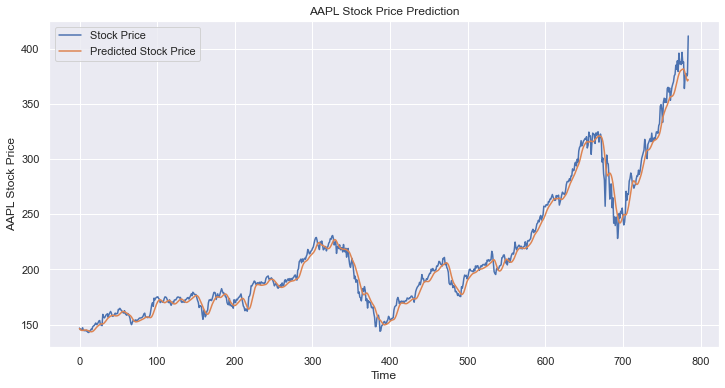

In [36]:
plt.figure(figsize=(12,6))
plt.plot(test_data, label = 'Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

#### A closer look:

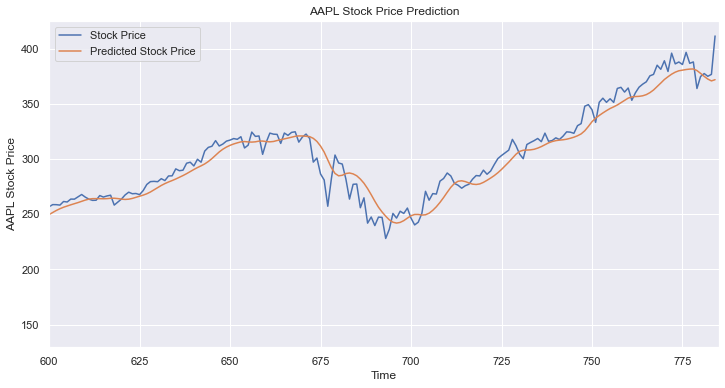

In [37]:
plt.figure(figsize=(12,6))
plt.plot(test_data, label = 'Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.xlim(600, len(test_data))
plt.show()

### While the predictions are much smoother than the actual price, it can still manage to capture the overall trends.

### This same model is also used on the 7-day rolling average:

In [38]:
#start at element 7 since elements 0-6 are NaN from taking the 7-day average
train_data_7=np.array(aapl_df.iloc[7:train_size,6])
test_data_7=np.array(aapl_df.iloc[train_size:,6])

In [39]:
#scaling the data
training_set_scaled = scaler.fit_transform(train_data_7.reshape(-1,1))
testing_set_scaled = scaler.fit_transform(test_data_7.reshape(-1,1))

In [40]:
#preparing the data to be used in the model
X_train = []
y_train = []
for i in range(len(train_data)-7-seq_length):
    X_train.append(training_set_scaled[i:i+seq_length, 0])
    y_train.append(training_set_scaled[i+seq_length, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [41]:
X_train.shape, y_train.shape

((3080, 50, 1), (3080,))

In [42]:
#creating the model in an identical manner to the previous one
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#the model is fitted on the training data over 50 epochs
#each epoch updates the model weights to try and make it more accurate
#the model will run through the training data 50 times
#a batch size of 30 means 30 data points are input into and processed in the model before updating the model's weights and parameters
#verbose controls how detailed the output is when training the model
#validation_split controls how much data is held out for validation, in this case we hold out 10%
history_7 = model.fit(X_train, y_train,
                    epochs=50, batch_size=30,
                    verbose=2, validation_split=0.1)

### We now plot the loss for the model fitted to the 7-day rolling average data.

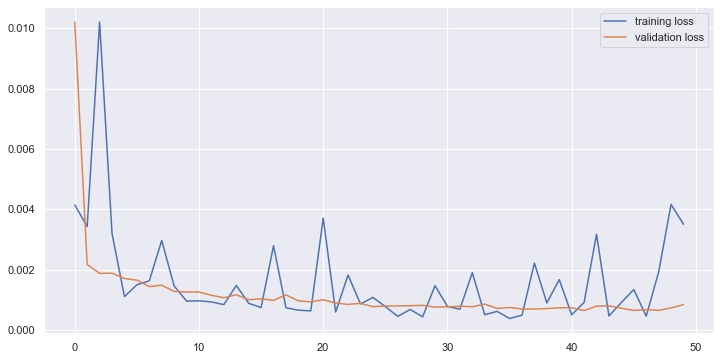

In [44]:
plt.figure(figsize=(12,6))
plt.plot(np.array(list(history_7.history.values()))[0]) #lineplot of the training loss
plt.plot(np.array(list(history_7.history.values()))[1]) #lineplot of the validation loss
plt.legend(['training loss','validation loss'])
plt.show()

### Like the previous model, the training loss slowly levels off after about 10 epochs with occasional fluctuations in the validation loss.

### We now preprocess the 7-day average data for the model in the same manner as the original stock data.

In [45]:
dataset_total = aapl_df.iloc[:,6] #use only the 6th column (close) of the apple dataframe

inputs = dataset_total[len(dataset_total) - len(test_data_7) - seq_length + 1:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(len(test_data)):
    X_test.append(inputs[i:i+seq_length, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_7 = model.predict(X_test)
predicted_stock_price_7 = scaler.inverse_transform(predicted_stock_price_7)

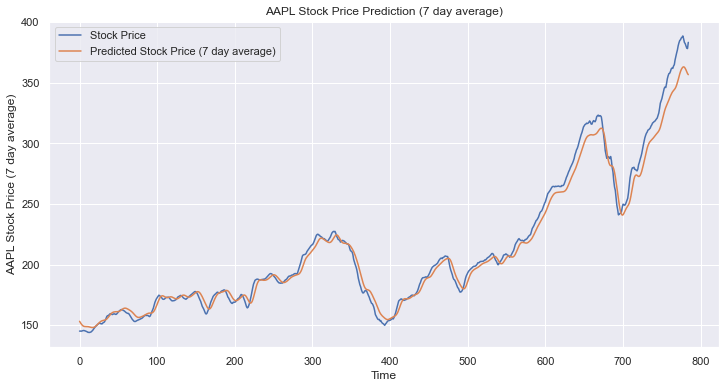

In [46]:
plt.figure(figsize=(12,6))
plt.plot(test_data_7, label = 'Stock Price')
plt.plot(predicted_stock_price_7, label = 'Predicted Stock Price (7 day average)')
plt.title('AAPL Stock Price Prediction (7 day average)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (7 day average)')
plt.legend()
plt.show()

#### A closer look:

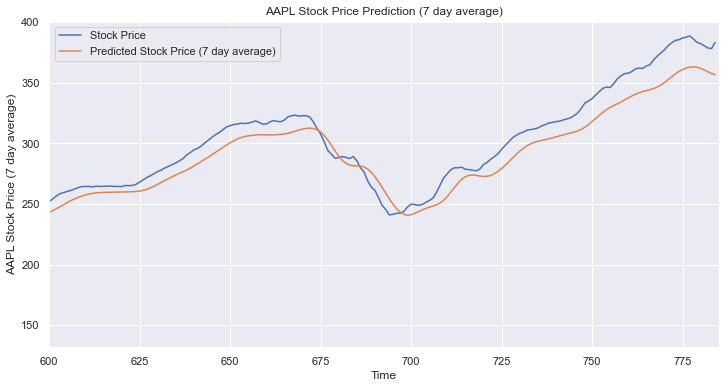

In [47]:
plt.figure(figsize=(12,6))
plt.plot(test_data_7, label = 'Stock Price')
plt.plot(predicted_stock_price_7, label = 'Predicted Stock Price (7 day average)')
plt.title('AAPL Stock Price Prediction (7 day average)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (7 day average)')
plt.xlim(600, len(test_data_7))
plt.legend()
plt.show()

#### The model's predictions are a bit smoother, but lag behind due to making and updating the predictions as it reads in the new data.

## Now we can add signals to the plot to identify when optimal times to buy/sell stocks occur.

In [49]:
#create a new dataframe called signals with the same index as the apple stock dataframe
signals = pd.DataFrame(index=aapl_df.index)

signals['signal'] = 0.0  #create a new column called signal and set each row to 0.0

In [50]:
#copy the moving average columns into the signals dataframe
signals['sma7']=aapl_df['sma7']
signals['sma30']=aapl_df['sma30']

In [51]:
#set the signal to 1 wherever the 7 day average is greater than the 30 day average
#set the signal to 0 wherever the 7 day average is less than the 30 day average
signals['signal'][7:]=np.where(signals['sma7'][7:] > signals['sma30'][7:], 1, 0)

In [52]:
#position takes the one-day difference of the signal column to decide when to purchase/sell the stock
#position of 0 means no decision/hold
#position of 1 (price begins to go back up after a dip) means buy the stock
#position of -1 (price begins to drop after a peak) means sell the stock
signals['position']=signals['signal'].diff()

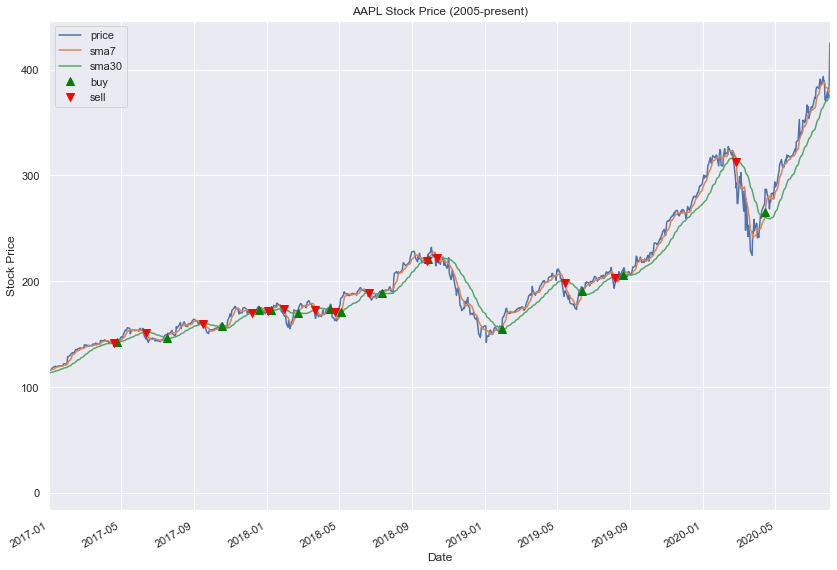

In [53]:
fig=plt.figure(figsize=(14,10))

ax1=fig.add_subplot(title="AAPL Stock Price (2005-present)", ylabel="Stock Price") #setup the plot figure/labels
aapl_df['Close'].plot(ax=ax1, label='price') #plot the actual closing price
aapl_df[['sma7', 'sma30']].plot(ax=ax1) #plot the 7- and 30-day moving averages

ax1.plot(signals.loc[signals['position']==1].index, #x-axis is dates where position is 1 (buy)
        signals['sma7'][signals['position']==1],    #y-axis is the actual value of the stock at this time
         '^', #mark on the graph where to buy
         markersize=8, color='green', label='buy')

ax1.plot(signals.loc[signals['position']==-1].index, #x-axis is dates where position is -1 (sell)
        signals['sma7'][signals['position']==-1], #y-axis is the actual value of the stock at this time
         'v', #mark on the graph where to sell
         markersize=8, color='red', label='sell')

#set the bounds of the graph to be from January 1, 2017 to today
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp.today())
plt.legend() #display the legend
plt.show()

### An important piece of information to take away from this model is that its primary goal is to follow past and recent trends in stock data, as opposed to making full-blown predictions about the price months in advance.